In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf

## looking at the data

In [19]:
train_df = pd.read_csv("training.csv")
valid_df = pd.read_csv("validation.csv")
test_df = pd.read_csv("test.csv")

In [98]:
new_df = pd.concat([train_df , valid_df , test_df] , axis=0 )
# Reset the index
new_df = new_df.reset_index(drop=True)

In [104]:
new_df.head(10)

,text,label,one_hot_label
0,i didnt feel humiliated,0,"[1, 0, 0, 0, 0, 0]"
1,i can go from feeling so hopeless to so damned...,0,"[1, 0, 0, 0, 0, 0]"
2,im grabbing a minute to post i feel greedy wrong,3,"[0, 0, 0, 1, 0, 0]"
3,i am ever feeling nostalgic about the fireplac...,2,"[0, 0, 1, 0, 0, 0]"
4,i am feeling grouchy,3,"[0, 0, 0, 1, 0, 0]"
5,ive been feeling a little burdened lately wasn...,0,"[1, 0, 0, 0, 0, 0]"
6,ive been taking or milligrams or times recomme...,5,"[0, 0, 0, 0, 0, 1]"
7,i feel as confused about life as a teenager or...,4,"[0, 0, 0, 0, 1, 0]"
8,i have been with petronas for years i feel tha...,1,"[0, 1, 0, 0, 0, 0]"
9,i feel romantic too,2,"[0, 0, 1, 0, 0, 0]"


In [105]:
new_df.one_hot_label.values

array([array([1, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 1, 0, 0]), ..., array([0, 1, 0, 0, 0, 0]),
       array([0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1, 0])], dtype=object)

In [106]:
new_df.isna().sum()

text             0
label            0
one_hot_label    0
dtype: int64

In [107]:
for i in range (6):

    print(new_df[new_df["label"] == i].shape)

(5797, 3)
(6761, 3)
(1641, 3)
(2709, 3)
(2373, 3)
(719, 3)


In [37]:
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [64]:
def make_one_hot(index):
    label = np.zeros(6).astype(int)
    # label = [0,0,0,0,0,0]
    label[index] = 1
    return label

In [65]:
make_one_hot(4)

array([0, 0, 0, 0, 1, 0])

In [103]:
new_df["one_hot_label"] = new_df["label"].apply(make_one_hot)

In [38]:
from tensorflow.keras.layers import TextVectorization

MAX_FEATURES = 200000

vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [112]:
vectorizer.adapt(new_df.text.values)

In [114]:
vectorized_text = vectorizer(new_df.text.values)
vectorized_text

<tf.Tensor: shape=(20000, 1800), dtype=int64, numpy=
array([[   2,  140,    3, ...,    0,    0,    0],
       [   2,   40,  102, ...,    0,    0,    0],
       [  16, 3360,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,    9, ...,    0,    0,    0],
       [  16,    8,   38, ...,    0,    0,    0],
       [   2,    3,   36, ...,    0,    0,    0]], dtype=int64)>

In [115]:
# tf.data.Dataset.from_tensor_slices(train_df["one_hot_label"].values[:3])
arr = np.stack(new_df["one_hot_label"].values[:3])
arr

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [116]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, np.stack(new_df["one_hot_label"].values)))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(tf.data.AUTOTUNE) # helps bottlenecks

In [117]:
dataset.as_numpy_iterator().next()

(array([[   2,    3, 3167, ...,    0,    0,    0],
        [   2,    3,  606, ...,    0,    0,    0],
        [   2,  796,   20, ...,    0,    0,    0],
        ...,
        [   2,  270,    3, ...,    0,    0,    0],
        [   2,   32,    3, ...,    0,    0,    0],
        [   2,    3,   14, ...,    0,    0,    0]], dtype=int64),
 array([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0]]))

In [118]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [125]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [126]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [128]:
history = model.fit(train, epochs=1, validation_data=val)

875/875 [==============================] - 1148s 1s/step - loss: 0.3416 - val_loss: 0.1884


<Figure size 800x500 with 0 Axes>

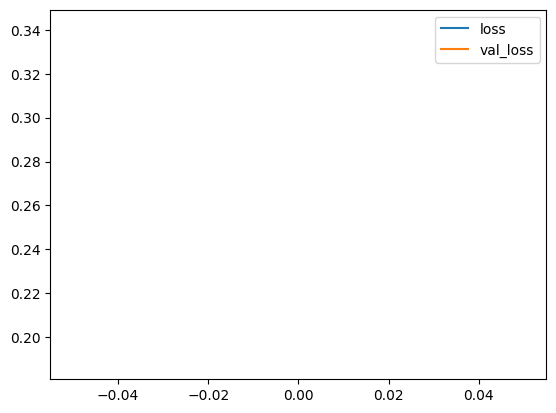

In [130]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [150]:
input = vectorizer("")


In [152]:
prediction = model.predict(tf.expand_dims(input , axis=0))

1/1 [==============================] - 0s 125ms/step


In [155]:
(prediction > 0.5).astype(int)

array([[0, 1, 0, 0, 0, 0]])

In [171]:
y_pred = model.predict(test)

125/125 [==============================] - 13s 105ms/step


In [173]:
y_pred[1900]

array([9.8275542e-01, 1.5620794e-02, 5.1336461e-03, 2.0152242e-03,
       1.6112305e-04, 6.9379515e-05], dtype=float32)

In [165]:
y_pred = (y_pred > 0.5).astype(int)

In [170]:
y_pred.shape

(2000, 6)

In [195]:
# Unbatch the dataset to get individual elements
unbatched_dataset = test.unbatch()

y_true = []
# Iterate through all elements
for index, element in enumerate(unbatched_dataset):
    y_true.append(element[1].numpy())


In [201]:
y_true = np.array(y_true)
y_true = np.stack(y_true)

In [202]:
y_true

array([[0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [183]:
# Assuming you have a tf.data.Dataset object called 'dataset'

# Define a lambda function to extract y values
get_y_value = lambda x, y: y

# Apply the lambda function to each element of the dataset
y_values_dataset = test.map(lambda x, y: get_y_value(x, y))

# Convert the dataset to a list to access all the y values
y_values = list(y_values_dataset.as_numpy_iterator())

f = 0
for i in range(1,17):
    s = y_values_dataset.as_numpy_iterator().next()
    print(s)
    f += 1

print(f)
# print(len(y_values))
# # Print the y values
# for y in y_values:
#     print(y)

[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]]
[[0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]
[[0 0 0 1 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]]
[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 

In [168]:
from sklearn.metrics import classification_report

print(classification_report(y_values , y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [125, 2000]